In [1]:
from scipy.io.wavfile import write
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
import numpy as np
import torch
#sys.path.append('waveglow/')

from hparams import create_hparams
from model import Tacotron2
from utils.data_utils import TextMelLoader
from modules.layers import TacotronSTFT, STFT
from utils.audio_processing import griffin_lim
from train import load_model
from sovattstps.tps import Handler
from text import text_to_sequence
from sovattstps.tps import prob2bool, symbols, cleaners

sys.path.insert(0, "C:/Users/nizhe/Desktop/Sova_TTS/sovattsvocoder")
from denoiser import Denoiser

handler = Handler("ru")



c:\Users\nizhe\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='lower', 
                       interpolation='none')

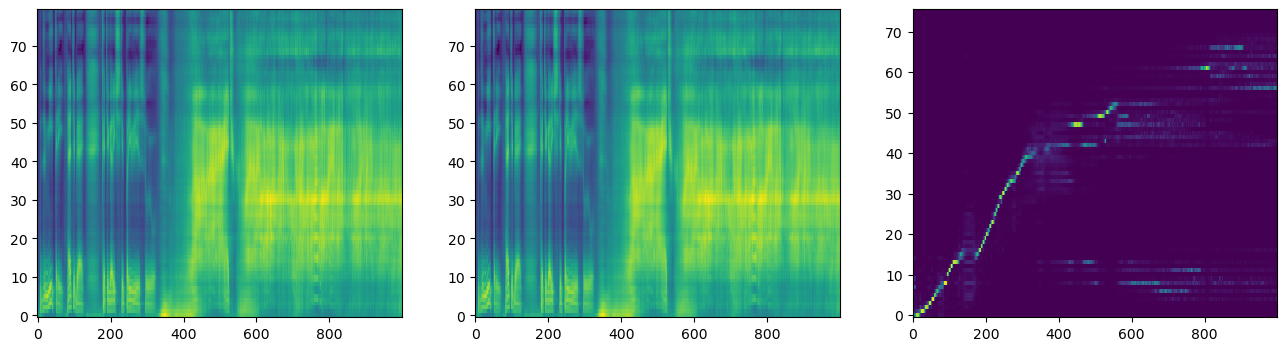

In [111]:
hparams = create_hparams("C:/Users/nizhe/Desktop/Sova_TTS/sovattsengine/data/hparams.yaml")
#hparams = create_hparams(r"C:\Users\nizhe\Desktop\123\sova-tts-binding\data\hparams.yaml")
text = "Дмитрий я тебя категорически приветствую Будь лапочкой не бухай скот+инана  ~"
#text = "Я вас категорически приветствую друзья"

#checkpoint_path = r"C:\Users\nizhe\Desktop\Sova_TTS\sovattsengine\outdir\checkpoint_0"
checkpoint_path = r"C:\Users\nizhe\Downloads\checkpointRuslan_41000"
#checkpoint_path = r"C:\Users\nizhe\Downloads\checkpoint1_16000"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

waveglow_path = r"C:\Users\nizhe\Desktop\123\sova-tts-binding\data\waveglow_ruslan.pt"
#waveglow_path = r"C:\Users\nizhe\Downloads\waveglow_256channels_ljs_v2.pt"
#waveglow_path = r"C:\Users\nizhe\Downloads\waveglow_256channels_universal_v5.pt"
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda()
#for k in waveglow.convinv:
#    k.float()
denoiser = Denoiser(waveglow)

sequence = handler.process_text(text, keep_delimiters=False)
sequence = handler.text2vec(sequence)
sequence = np.array([sequence])
#print(sequence)
#sequence = np.array(text_to_sequence(text, ['basic_cleaners']))[None, :]
#print(sequence)


sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
#    audio1 = 32768.0 * waveglow.infer(mel_outputs_postnet, sigma=0.666)[0]

#audio = audio1.cpu().numpy()
#audio = audio.astype('int16')
#write("123456.wav", 22050, audio)
#ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#audio_denoised = denoiser(audio1)[:, 0]
#audio_denoised = audio_denoised.cpu().numpy()
#audio_denoised = audio_denoised.astype('int16')
#write("123de.wav", 22050, audio_denoised)
audio_denoised = denoiser(audio, strength=0.01)[:, 0]
ipd.Audio(audio_denoised.cpu().numpy(), rate=hparams.sampling_rate)
audio_denoised = 32768.0 * audio_denoised
audio_denoised = audio_denoised.cpu().numpy()
audio_denoised = audio_denoised.astype('int16')
write("123de.wav", 22050, audio_denoised.T)
